Adopted from https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [1]:
# load and clean-up data
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric
from numpy import split
from numpy import array
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D

Using TensorFlow backend.


# Pre processing
* Fill missing values
* Downsample to days
* Overlaping Windows of weekly groups
* Batch by week

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!unzip household_power_consumption.zip
!ls

--2019-08-29 01:34:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/x-httpd-php]
Saving to: ‘household_power_consumption.zip.2’

household_power_con 100%[===================>]  19.68M  48.4MB/s    in 0.4s    

2019-08-29 01:34:40 (48.4 MB/s) - ‘household_power_consumption.zip.2’ saved [20640916/20640916]

Archive:  household_power_consumption.zip
replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: household_power_consumption.txt  
household_power_consumption.csv       household_power_consumption.zip.1
household_power_consumption_days.csv  household_power_consumption.zip.2
household_power_consumption.txt       sample_data
household_power_consumption.zip


In [0]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

In [4]:
# resample minute data to total for each day
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  ...  sub_metering_4
datetime                         ...                
2006-12-16             1209.176  ...    14680.933319
2006-12-17             3390.460  ...    36946.666732
2006-12-18             2203.826  ...    19028.433281
2006-12-19             1666.194  ...    13131.900043
2006-12-20             2225.748  ...    20384.800011

[5 rows x 8 columns]


In [5]:
# split into standard weeks

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


## LSTM Model With Univariate Input and Vector Output

In [0]:

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))


# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

## Encoder-Decoder LSTM Model With Multivariate Input

In [0]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)
 
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output intodel = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')o [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    m
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model
 
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [8]:
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)

W0829 01:35:43.681224 140308922886016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 01:35:43.695527 140308922886016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 01:35:43.700978 140308922886016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 01:35:44.243808 140308922886016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0829 01:35:44.491538 140308922886016 deprecation.py:323

Epoch 1/50
1092/1092 [==============================] - 5s 5ms/step - loss: 70198929.2747
Epoch 2/50
1092/1092 [==============================] - 4s 3ms/step - loss: 17801250.2692
Epoch 3/50
1092/1092 [==============================] - 4s 3ms/step - loss: 30534912.9886
Epoch 4/50
1092/1092 [==============================] - 4s 3ms/step - loss: 9557669.4826
Epoch 5/50
1092/1092 [==============================] - 4s 3ms/step - loss: 9601723.3755
Epoch 6/50
1092/1092 [==============================] - 4s 3ms/step - loss: 494840.9578
Epoch 7/50
1092/1092 [==============================] - 4s 3ms/step - loss: 968144.1209
Epoch 8/50
1092/1092 [==============================] - 4s 3ms/step - loss: 411801.9886
Epoch 9/50
1092/1092 [==============================] - 4s 3ms/step - loss: 371059.1783
Epoch 10/50
1092/1092 [==============================] - 4s 3ms/step - loss: 323876.6389
Epoch 11/50
1092/1092 [==============================] - 4s 3ms/step - loss: 324740.2802
Epoch 12/50
1092/1092 

In [9]:
# summarize scores
summarize_scores('lstm', score, scores)

lstm: [381.390] 378.5, 383.7, 343.2, 394.3, 373.5, 322.6, 459.2


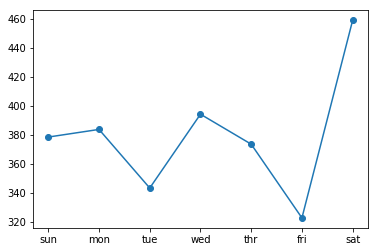

In [10]:
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()